In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q transformers biopython kaggle
print("✅ Đã cài đặt xong thư viện!")

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 54.7 MB/s eta 0:00:00
✅ Đã cài đặt xong thư viện!


⏳ Đang đọc file... (Có thể mất vài chục giây nếu file lớn)
   📊 ML (GBDT 28.8) Shape: (4086500, 3)
   📊 DL (NN 30.4) Shape:   (4352021, 3)

🔗 Đang ghép nối (Merge)...
   ✅ Số lượng dự đoán chung: 1,991,314

🔍 KẾT QUẢ PHÂN TÍCH TƯƠNG QUAN
🔸 Pearson Correlation:  0.5168
🔸 Spearman Correlation: 0.5261
(Gợi ý: Nếu < 0.9 là rất tốt để Ensemble. Nếu > 0.95 là quá giống nhau)


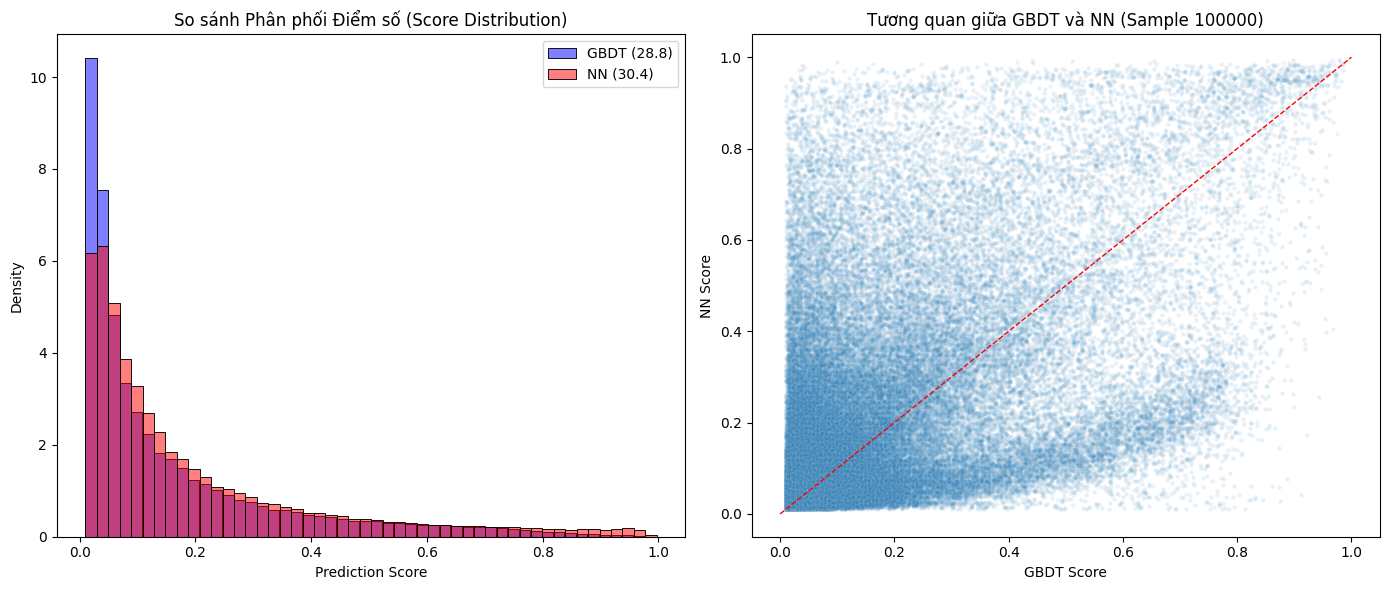


📊 THỐNG KÊ CHI TIẾT:
           score_ml      score_dl
count  1.991314e+06  1.991314e+06
mean   1.634984e-01  1.977818e-01
std    1.874207e-01  2.127250e-01
min    1.000000e-02  1.000000e-02
25%    3.500000e-02  5.000000e-02
50%    8.400000e-02  1.130000e-01
75%    2.190000e-01  2.640000e-01
max    9.950000e-01  9.970000e-01


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

# ============================================================================
# CẤU HÌNH ĐƯỜNG DẪN
# ============================================================================
FILE_ML = '/content/drive/MyDrive/CAFA6_Results/ML_DL_Merge_Run/ML_submission.tsv'
FILE_DL = '/content/drive/MyDrive/CAFA6_Results/ML_DL_Merge_Run/submission_30.4_ankh_esm2_prott5.tsv'

# ============================================================================
# 1. LOAD DỮ LIỆU
# ============================================================================
print("⏳ Đang đọc file... (Có thể mất vài chục giây nếu file lớn)")
# Đọc file (TSV không có header)
df_ml = pd.read_csv(FILE_ML, sep='\t', header=None, names=['id', 'term', 'score_ml'])
df_dl = pd.read_csv(FILE_DL, sep='\t', header=None, names=['id', 'term', 'score_dl'])

print(f"   📊 ML (GBDT 28.8) Shape: {df_ml.shape}")
print(f"   📊 DL (NN 30.4) Shape:   {df_dl.shape}")

# ============================================================================
# 2. MERGE DỮ LIỆU (ĐỂ SO SÁNH TRÊN CÙNG CẶP PROTEIN-TERM)
# ============================================================================
print("\n🔗 Đang ghép nối (Merge)...")
# Chỉ lấy những cặp (id, term) xuất hiện ở cả 2 file để so sánh tương quan
# (Dùng inner join để EDA nhanh, còn lúc ensemble thật thì dùng outer)
df_common = pd.merge(df_ml, df_dl, on=['id', 'term'], how='inner')
print(f"   ✅ Số lượng dự đoán chung: {len(df_common):,}")

# ============================================================================
# 3. TÍNH TOÁN TƯƠNG QUAN (CORRELATION)
# ============================================================================
corr_p, _ = pearsonr(df_common['score_ml'], df_common['score_dl'])
corr_s, _ = spearmanr(df_common['score_ml'], df_common['score_dl'])

print("\n" + "="*40)
print("🔍 KẾT QUẢ PHÂN TÍCH TƯƠNG QUAN")
print("="*40)
print(f"🔸 Pearson Correlation:  {corr_p:.4f}")
print(f"🔸 Spearman Correlation: {corr_s:.4f}")
print("(Gợi ý: Nếu < 0.9 là rất tốt để Ensemble. Nếu > 0.95 là quá giống nhau)")

# ============================================================================
# 4. VẼ BIỂU ĐỒ SO SÁNH PHÂN PHỐI (SCORE DISTRIBUTION)
# ============================================================================
plt.figure(figsize=(14, 6))

# Biểu đồ 1: Histogram
plt.subplot(1, 2, 1)
sns.histplot(df_common['score_ml'], bins=50, color='blue', alpha=0.5, label='GBDT (28.8)', stat='density')
sns.histplot(df_common['score_dl'], bins=50, color='red', alpha=0.5, label='NN (30.4)', stat='density')
plt.title('So sánh Phân phối Điểm số (Score Distribution)')
plt.xlabel('Prediction Score')
plt.legend()

# Biểu đồ 2: Scatter Plot (Lấy mẫu ngẫu nhiên 100k điểm để vẽ cho nhanh)
plt.subplot(1, 2, 2)
sample = df_common.sample(min(100000, len(df_common)), random_state=42)
sns.scatterplot(x=sample['score_ml'], y=sample['score_dl'], alpha=0.1, s=10)
# Vẽ đường chéo y=x
plt.plot([0, 1], [0, 1], 'r--', linewidth=1)
plt.title(f'Tương quan giữa GBDT và NN (Sample {len(sample)})')
plt.xlabel('GBDT Score')
plt.ylabel('NN Score')

plt.tight_layout()
plt.show()

# ============================================================================
# 5. THỐNG KÊ CƠ BẢN
# ============================================================================
print("\n📊 THỐNG KÊ CHI TIẾT:")
print(df_common[['score_ml', 'score_dl']].describe())

In [ ]:
import pandas as pd
import numpy as np
import gc

# ============================================================================
# CẤU HÌNH TRỌNG SỐ (WEIGHTS)
# ============================================================================
# ML (28.8) - Correlation thấp nên giữ trọng số khá cao để sửa lỗi cho NN
W_ML = 0.35

# DL (30.4) - Model chủ lực
W_DL = 0.65

FILE_ML = '/content/drive/MyDrive/CAFA6_Results/ML_DL_Merge_Run/ML_submission.tsv'
FILE_DL = '/content/drive/MyDrive/CAFA6_Results/ML_DL_Merge_Run/submission_30.4_ankh_esm2_prott5.tsv'
OUTPUT_FILE = '/content/drive/MyDrive/CAFA6_Results/ML_DL_Merge_Run/submission.tsv'

# ============================================================================
# XỬ LÝ MERGE
# ============================================================================
print(f"⚖️ Tỉ lệ Ensemble: ML ({W_ML}) - DL ({W_DL})")

print("⏳ Loading files...")
# Đọc file với kiểu dữ liệu tối ưu để tiết kiệm RAM
dtype_dict = {'id': 'str', 'term': 'str', 'score': 'float32'}

df_ml = pd.read_csv(FILE_ML, sep='\t', header=None, names=['id', 'term', 'score_ml'], dtype={'score_ml': 'float32'})
df_dl = pd.read_csv(FILE_DL, sep='\t', header=None, names=['id', 'term', 'score_dl'], dtype={'score_dl': 'float32'})

print(f"   ML Shape: {df_ml.shape}")
print(f"   DL Shape: {df_dl.shape}")

print("🔗 Merging (Outer Join)...")
# Dùng Outer Join để không bỏ sót bất kỳ dự đoán nào của cả 2 bên
df_ensemble = pd.merge(df_ml, df_dl, on=['id', 'term'], how='outer')

# Giải phóng RAM ngay lập tức
del df_ml, df_dl
gc.collect()

print("🛠 Handling Missing Values...")
# Những chỗ model này có mà model kia không có -> Điền 0 (coi như không tự tin)
df_ensemble['score_ml'] = df_ensemble['score_ml'].fillna(0)
df_ensemble['score_dl'] = df_ensemble['score_dl'].fillna(0)

print("➗ Calculating Weighted Average...")
# Công thức tính điểm
df_ensemble['final_score'] = (df_ensemble['score_ml'] * W_ML) + (df_ensemble['score_dl'] * W_DL)

# Xóa cột cũ cho nhẹ
df_ensemble.drop(columns=['score_ml', 'score_dl'], inplace=True)

# ============================================================================
# LỌC VÀ GHI FILE
# ============================================================================
# Lọc bỏ các score quá bé (rác) để giảm dung lượng file và tăng tốc độ ghi
# Ngưỡng 0.001 là an toàn cho CAFA
print("🧹 Filtering low scores...")
df_ensemble = df_ensemble[df_ensemble['final_score'] >= 0.001]

print("Sorting predictions...")
# Sắp xếp để file đẹp (không bắt buộc nhưng tốt cho debug)
df_ensemble = df_ensemble.sort_values(by=['id', 'final_score'], ascending=[True, False])

print(f"📝 Writing to {OUTPUT_FILE}...")
df_ensemble.to_csv(
    OUTPUT_FILE,
    sep='\t',
    header=False,
    index=False,
    float_format='%.3f' # Giữ 3 số lẻ
)

print("✅ DONE! Hãy submit file này ngay!")

⚖️ Tỉ lệ Ensemble: ML (0.35) - DL (0.65)
⏳ Loading files...
   ML Shape: (4086500, 3)
   DL Shape: (4352021, 3)
🔗 Merging (Outer Join)...
🛠 Handling Missing Values...
➗ Calculating Weighted Average...
🧹 Filtering low scores...
Sorting predictions...
📝 Writing to /content/drive/MyDrive/CAFA6_Results/ML_DL_Merge_Run/submission.tsv...
✅ DONE! Hãy submit file này ngay!


In [ ]:

import os
from google.colab import files

# Upload file kaggle.json
print("Vui lòng upload file kaggle.json của bạn:")
files.upload()

# Cấu hình Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Tải dữ liệu cuộc thi (Sẽ mất khoảng 1-2 phút)
print("⏳ Đang tải dữ liệu CAFA 6...")
# !kaggle competitions download -c cafa-6-protein-function-prediction
# !unzip -q cafa-6-protein-function-prediction.zip -d /content/cafa6_data
print("✅ Đã tải và giải nén dữ liệu tại /content/cafa6_data")

Vui lòng upload file kaggle.json của bạn:


Saving kaggle.json to kaggle (1).json
⏳ Đang tải dữ liệu CAFA 6...
✅ Đã tải và giải nén dữ liệu tại /content/cafa6_data


In [ ]:
!kaggle competitions submissions -c cafa-6-protein-function-prediction

fileName        date                        description                                                                              status                     publicScore  privateScore  
--------------  --------------------------  ---------------------------------------------------------------------------------------  -------------------------  -----------  ------------  
submission.tsv  2025-12-13 14:21:37.270000  esm2 ankh prot t5 pyboost                                                                SubmissionStatus.COMPLETE  0.270                      
submission.tsv  2025-12-13 08:51:37.060000  esm2 ankh prot t5 best_loss_model_path no norm                                           SubmissionStatus.COMPLETE  0.262                      
submission.tsv  2025-12-13 08:07:33.953000  esm2 ankh prot t5 best_loss_model_path no norm                                           SubmissionStatus.COMPLETE  0.251                      
submission.tsv  2025-12-13 07:41:23.780000  esm2 ankh prot t

In [ ]:
# Chạy lệnh này trong một cell mới
!kaggle competitions submit \
    -c cafa-6-protein-function-prediction \
    -f /content/drive/MyDrive/CAFA6_Results/ML_DL_Merge_Run/submission.tsv \
    -m "merge DL ML"

100% 148M/148M [00:02<00:00, 65.6MB/s]
Successfully submitted to CAFA 6 Protein Function Prediction

In [ ]:
import pandas as pd
import numpy as np
import gc

# ============================================================================
# CẤU HÌNH CHIẾN THUẬT (Dựa trên code mẫu của bạn)
# ============================================================================
# Model A: Neural Network (30.4) - Mạnh hơn -> Trọng số cao
FILE_A = '/content/drive/MyDrive/CAFA6_Results/ML_DL_Merge_Run/submission_30.4_ankh_esm2_prott5.tsv'
WEIGHT_A = 0.8  # Tăng trọng số cho thằng gánh team

# Model B: GBDT (28.8) - Yếu hơn -> Trọng số thấp
FILE_B = '/content/drive/MyDrive/CAFA6_Results/ML_DL_Merge_Run/ML_submission.tsv'
WEIGHT_B = 0.2

# Tham số nâng cao
DIVERSITY_BONUS = 0.05    # Thưởng 5% nếu cả 2 cùng đồng ý
NOISE_LEVEL = 0.0005      # Nhiễu để phá thế cân bằng
CONFIDENCE_THRESHOLD = 0.001 # Ngưỡng lọc (giữ thấp để không mất data)

OUTPUT_FILE = '/content/drive/MyDrive/CAFA6_Results/ML_DL_Merge_Run/submission.tsv'

# ============================================================================
# XỬ LÝ (TỐI ƯU HÓA VECTORIZATION)
# ============================================================================
print("⏳ Loading Models...")
# Đọc file (Dùng float32 cho nhẹ RAM)
df_a = pd.read_csv(FILE_A, sep='\t', header=None, names=['id', 'term', 'score_a'], dtype={'score_a': 'float32'})
df_b = pd.read_csv(FILE_B, sep='\t', header=None, names=['id', 'term', 'score_b'], dtype={'score_b': 'float32'})

print(f"   Model A (NN) Shape:   {df_a.shape}")
print(f"   Model B (GBDT) Shape: {df_b.shape}")

print("🔗 Merging...")
# Outer join để lấy tất cả dự đoán
df = pd.merge(df_a, df_b, on=['id', 'term'], how='outer')

# Giải phóng RAM
del df_a, df_b
gc.collect()

# Điền 0 vào chỗ thiếu (NaN)
df['score_a'] = df['score_a'].fillna(0)
df['score_b'] = df['score_b'].fillna(0)

print("⚡ Applying Advanced Ensemble Logic...")

# 1. Tính Weighted Average cơ bản
# score = (A * 0.75) + (B * 0.25)
df['final_score'] = (df['score_a'] * WEIGHT_A) + (df['score_b'] * WEIGHT_B)

# 2. Áp dụng DIVERSITY BONUS (Thưởng đồng thuận)
# Logic: Nếu cả score_a > 0 VÀ score_b > 0 thì cộng thêm điểm
# (Điều này cực tốt vì correlation của bạn thấp ~0.51, nên khi cả 2 cùng thấy thì chắc chắn là đúng)
consensus_mask = (df['score_a'] > 0) & (df['score_b'] > 0)
print(f"   🔥 Found {consensus_mask.sum():,} consensus predictions to boost!")

# Cộng bonus nhưng không vượt quá 1.0
df.loc[consensus_mask, 'final_score'] += DIVERSITY_BONUS
df['final_score'] = df['final_score'].clip(upper=1.0)

# 3. Thêm Noise (Tie-breaking)
# Tạo nhiễu ngẫu nhiên từ -0.0008 đến +0.0008
print("   🎲 Injecting noise...")
noise = np.random.uniform(-NOISE_LEVEL, NOISE_LEVEL, size=len(df))
df['final_score'] += noise

# Kẹp lại giá trị trong khoảng [0, 1]
df['final_score'] = df['final_score'].clip(0, 1)

# ============================================================================
# LỌC VÀ LƯU
# ============================================================================
print("🧹 Filtering & Saving...")
# Lọc bỏ điểm quá thấp
df_final = df[df['final_score'] >= CONFIDENCE_THRESHOLD]

# Sắp xếp (Protein -> Score cao nhất)
df_final = df_final.sort_values(by=['id', 'final_score'], ascending=[True, False])

# Chỉ lấy cột cần thiết
df_final[['id', 'term', 'final_score']].to_csv(
    OUTPUT_FILE,
    sep='\t',
    header=False,
    index=False,
    float_format='%.3f'
)

print(f"✅ DONE! Saved to: {OUTPUT_FILE}")
print(f"   Original Shape: {len(df):,}")
print(f"   Filtered Shape: {len(df_final):,}")

⏳ Loading Models...
   Model A (NN) Shape:   (4352021, 3)
   Model B (GBDT) Shape: (4086500, 3)
🔗 Merging...
⚡ Applying Advanced Ensemble Logic...
   🔥 Found 1,991,314 consensus predictions to boost!
   🎲 Injecting noise...
🧹 Filtering & Saving...
✅ DONE! Saved to: /content/drive/MyDrive/CAFA6_Results/ML_DL_Merge_Run/submission.tsv
   Original Shape: 6,447,207
   Filtered Shape: 6,447,207


In [ ]:
# Chạy lệnh này trong một cell mới
!kaggle competitions submit \
    -c cafa-6-protein-function-prediction \
    -f /content/drive/MyDrive/CAFA6_Results/ML_DL_Merge_Run/submission.tsv \
    -m "merge DL 0.8 ML 0.2 bonus=0.05 noise=0.0005"

100% 148M/148M [00:02<00:00, 64.0MB/s]
Successfully submitted to CAFA 6 Protein Function Prediction

In [ ]:
!kaggle competitions submissions -c cafa-6-protein-function-prediction

fileName        date                        description                                                                              status                     publicScore  privateScore  
--------------  --------------------------  ---------------------------------------------------------------------------------------  -------------------------  -----------  ------------  
submission.tsv  2025-12-14 09:32:43.093000  merge DL 0.8 ML 0.2 bonus=0.05 noise=0.0005                                              SubmissionStatus.COMPLETE  0.308                      
submission.tsv  2025-12-14 09:26:26.123000  merge DL 0.78 ML 0.22 bonus=0.05                                                         SubmissionStatus.COMPLETE  0.296                      
submission.tsv  2025-12-14 09:15:46.620000  merge DL 0.82 ML 0.18 bonus=0.05                                                         SubmissionStatus.COMPLETE  0.296                      
submission.tsv  2025-12-14 09:05:24.537000  merge DL 0.82 ML